# m2.1t.jl

Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/dev/Turing/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Compute the maximum_a_posteriori

In [7]:
maximum_a_posteriori(model, lb, ub)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.4052095935304474]
 * Minimizer: [0.6666666665609615]
 * Minimum: 1.297811e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 8.71e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.18e-13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.53e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 52
 * Gradient Calls: 52

Use Turing mcmc

In [8]:
chn = sample(model, Turing.NUTS(2000, 1000, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.8
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:235
┌ Warning: 8.542330530368847 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.172458436272994 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.0889237828939065 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 28.32608822066982 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.391367814219694 exceeds 5.0; capped to

Fix the inclusion of adaptation samples

In [9]:
chn2 = MCMCChains.Chains(chn.value[1001:2000,:,:],
  vcat(chn.name_map[:internals], chn.name_map[:parameters]),
  Dict(
    :parameters => chn.name_map[:parameters],
    :internals => chn.name_map[:internals]
  )
)

Object of type "Chains{Union{Missing, Float64},Float64,NamedTuple{(:internals, :parameters),Tuple{Array{String,1},Array{String,1}}},NamedTuple{(),Tuple{}}}"

Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = theta



Show corrected results (drop adaptation samples)

In [10]:
names = ["theta"]
a3d = chn[:theta]
chn2 = MCMCChains.Chains(a3d[1001:2000,:,:],
  names,
  Dict(
    :parameters => names
  )
)

Object of type "Chains{Union{Missing, Float64},Float64,NamedTuple{(:parameters,),Tuple{Array{String,1}}},NamedTuple{(),Tuple{}}}"

Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = theta



Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = theta

Empirical Posterior Estimates:
parameters
       Mean    SD   Naive SE  MCSE     ESS  
theta 0.6445 0.1407   0.0044 0.0065 466.3342

Quantiles:
parameters
       2.5%   25.0%  50.0%  75.0%  97.5%
theta 0.1712 0.5534 0.6601 0.7423 0.9649



Show the hpd region

In [12]:
MCMCChains.hpd(chn2, alpha=0.055)

Iterations        = 1:1000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = theta

parameters
      94.5% Lower 94.5% Upper
theta  0.36864767  0.88663963



Compute the hpd bounds for plotting

In [13]:
d, p, c = size(chn2);
theta = convert(Vector{Float64}, reshape(chn2[:theta], d));
bnds = quantile(theta, [0.045, 0.955])

2-element Array{Float64,1}:
 0.37923092776867817
 0.8606062604430911 

Show hpd region

In [14]:
println("hpd bounds = $bnds\n")

hpd bounds = [0.37923092776867817, 0.8606062604430911]



analytical calculation

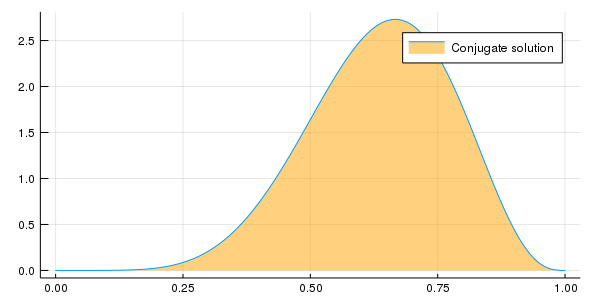

In [15]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

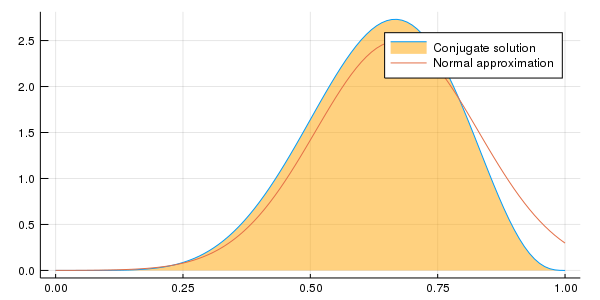

In [16]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

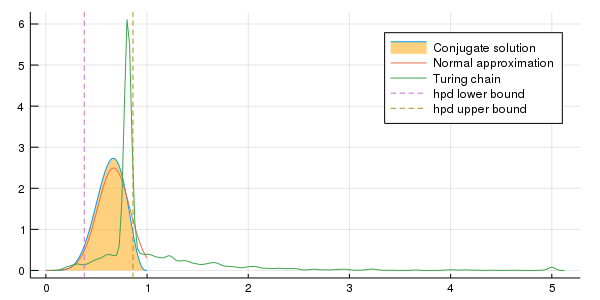

In [17]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 2, 1], lab="Turing chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

End of `02/m2.1t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*